In [1]:
!pip install datasets==2.1.0 seaborn==0.11.2 scikit-learn==1.0.2 gensim==4.2.0 nltk==3.7 pymystem3==0.2.0 pyLDAvis==3.3.1

     |████████████████████████████████| 325 kB 5.4 MB/s 
     |████████████████████████████████| 24.1 MB 46.1 MB/s 
     |████████████████████████████████| 1.5 MB 36.5 MB/s 
     |████████████████████████████████| 1.7 MB 37.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 212 kB 11.1 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 25.7 MB/s 
     |████████████████████████████████| 136 kB 48.9 MB/s 
     |████████████████████████████████| 749 kB 41.6 MB/s 
     |████████████████████████████████| 127 kB 55.3 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 271 kB 47.6 MB/s 
     |████████████████████████████████| 144 kB 46.4 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=1

In [2]:
!python -m nltk.downloader stopwords

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from datasets import load_dataset
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from string import punctuation

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

nltk.download("stopwords")

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
dataset = load_dataset("surdan/nerel_short")

Downloading:   0%|          | 0.00/924 [00:00<?, ?B/s]

Using custom data configuration surdan--for_test_v3-eb84b899e14cc88e


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/surdan--for_test_v3-eb84b899e14cc88e/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/MLcourse/NLP/id_to_label_map.pickle', 'rb') as f:
    mapper = pickle.load(f)

In [27]:
mapper

{0: 'O',
 1: 'I-AGE',
 2: 'B-AGE',
 3: 'B-AWARD',
 4: 'I-AWARD',
 5: 'B-CITY',
 6: 'I-CITY',
 7: 'B-COUNTRY',
 8: 'I-COUNTRY',
 9: 'B-CRIME',
 10: 'I-CRIME',
 11: 'B-DATE',
 12: 'I-DATE',
 13: 'B-DISEASE',
 14: 'I-DISEASE',
 15: 'B-DISTRICT',
 16: 'I-DISTRICT',
 17: 'B-EVENT',
 18: 'I-EVENT',
 19: 'B-FACILITY',
 20: 'I-FACILITY',
 21: 'B-FAMILY',
 22: 'I-FAMILY',
 23: 'B-IDEOLOGY',
 24: 'I-IDEOLOGY',
 25: 'B-LANGUAGE',
 26: 'I-LAW',
 27: 'B-LAW',
 28: 'B-LOCATION',
 29: 'I-LOCATION',
 30: 'B-MONEY',
 31: 'I-MONEY',
 32: 'B-NATIONALITY',
 33: 'I-NATIONALITY',
 34: 'B-NUMBER',
 35: 'I-NUMBER',
 36: 'B-ORDINAL',
 37: 'I-ORDINAL',
 38: 'B-ORGANIZATION',
 39: 'I-ORGANIZATION',
 40: 'B-PENALTY',
 41: 'I-PENALTY',
 42: 'B-PERCENT',
 43: 'I-PERCENT',
 44: 'B-PERSON',
 45: 'I-PERSON',
 46: 'I-PRODUCT',
 47: 'B-PRODUCT',
 48: 'B-PROFESSION',
 49: 'I-PROFESSION',
 50: 'B-RELIGION',
 51: 'I-RELIGION',
 52: 'B-STATE_OR_PROVINCE',
 53: 'I-STATE_OR_PROVINCE',
 54: 'B-TIME',
 55: 'I-TIME',
 56: 'B-WOR

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sequences', 'ids'],
        num_rows: 2508
    })
    test: Dataset({
        features: ['sequences', 'ids'],
        num_rows: 512
    })
    dev: Dataset({
        features: ['sequences', 'ids'],
        num_rows: 536
    })
})

In [44]:
print(dataset["train"]["sequences"])


[['Виталий', 'Кличко', 'хочет', 'стать', 'мэром', 'Киева', 'Бывший', 'чемпион', 'мира', 'по', 'боксу', 'в', 'тяжёлом', 'весе', 'Виталий', 'Кличко', 'в', 'марте', 'будет', 'баллотироваться', 'на', 'пост', 'мэра', 'столицы', 'Украины', 'Киева'], ['Я', 'хочу', 'стать', 'мэром', 'Киева', 'так', 'как', 'я', 'очень', 'люблю', 'этот', 'город', 'и', 'хочу', 'улучшить', 'жизнь', 'в', 'нём', 'Я', 'готов', 'к', 'этому', 'шагу', 'и', 'сознаю', 'огромную', 'ответственность', 'в', 'этом', 'деле', 'так', 'сказал', 'Кличко', 'на', 'в', 'четверг'], ['Виталий', 'Кличко', 'был', 'чемпионом', 'мира', 'по', 'версии', 'WBC'], ['преследовавших', 'его', 'травм', 'в', 'ноябре', '2005', 'года', 'он', 'закончил', 'свою', 'боксёрскую', 'карьеру', 'На', 'выборы', 'мэра', 'Кличко', 'будет', 'идти', 'от', 'демократического', 'блока', 'сформированного', 'вокруг', 'молодёжного', 'движения', 'Пора', 'В', 'случае', 'победы', 'Кличко', 'обещает', 'бороться', 'с', 'коррупцией', 'и', 'способствовать', 'экономическому', 'ро

In [ ]:
print(dataset["train"]['ids'])

[[44, 45, 0, 0, 48, 5, 0, 3, 4, 0, 0, 0, 0, 0, 44, 45, 11, 12, 0, 0, 0, 0, 48, 0, 7, 5], [0, 0, 0, 48, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 0, 11, 12], [44, 45, 0, 3, 4, 0, 0, 38], [0, 0, 0, 11, 12, 12, 12, 0, 0, 0, 48, 0, 0, 17, 48, 44, 0, 0, 0, 23, 0, 0, 0, 0, 0, 38, 0, 0, 0, 44, 0, 0, 0, 9, 0, 0, 0, 0, 5], [0, 0, 17, 44, 45, 44, 45, 17, 0, 0, 0, 0, 11, 12, 12, 12, 0, 0, 0, 0, 0, 0, 17, 44, 45, 44, 45, 17, 54, 55, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 19, 20, 0, 19, 20, 44, 45, 0, 17, 28, 29, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 39, 39, 39, 38, 39, 39, 38, 7, 0, 0, 17, 0, 0, 0, 0, 0, 0, 44, 0, 0, 0, 0, 0, 52, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 48], [48, 49, 49, 49, 49, 49, 49, 49, 49, 38, 39, 39, 39, 39, 39, 39, 39, 38, 39, 39, 38, 7, 0, 5, 44, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
import numpy as np
i = np.random.randint(0, len(dataset["train"]))

print(dataset["train"][i]["sequences"])


['Суга', 'занимал', 'пост', 'министра', 'внутренних', 'дел', 'и', 'коммуникаций', 'в', 'предыдущем', 'кабинете', 'Синдзо', 'Абэ', 'Синдзо', 'Абэ', 'до', '2007', 'года']


In [8]:
pip install pymorphy2

     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 8.9 MB/s 


In [9]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer() 

In [20]:
import tqdm
cache = {}


def lemmatize_text(text):
    tokens = []

    for word in text:
      if word not in cache:
        cache[word] = morph.parse(word)[0].normal_form
      tokens.append(cache[word])
    
    text = " ".join(tokens)
    
    return text

lemmatized = list(
    tqdm.tqdm(map(lemmatize_text, dataset['train']["sequences"]),
              total=len(dataset['train'])))

100%|██████████| 2508/2508 [00:04<00:00, 514.84it/s]


In [21]:
lemmatized[0]

'виталий кличко хотеть стать мэр киев бывший чемпион мир по бокс в тяжёлый вес виталий кличко в март быть баллотироваться на пост мэр столица украина киев'

In [22]:
from typing import List

def flatten(sentences: List[List[str]]) -> List[str]:
    result = []
    for sentence in sentences:
        result += sentence
    return result

words = flatten(map(lambda text: text.split(), lemmatized))
n_words = len(words)
n_unique_words = len(set(words))

print("{:,} кол-во примеров".format(len(dataset["train"])))
print("{:,} слов".format(n_words))
print("{:,} уникальных слов".format(n_unique_words))

2,508 кол-во примеров
81,072 слов
10,880 уникальных слов


In [23]:
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


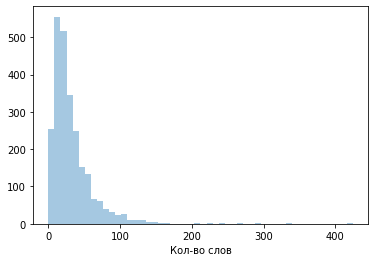

In [24]:
sentences_length_list = list(map(lambda text: len(text), dataset['train']["sequences"]))

sns.distplot(
    pd.Series(sentences_length_list, name="Кол-во слов"),
    label="Распределение кол-ва слов",
    kde=False
)

In [25]:
# Топ 50 часто используемых слов
pd.Series(words).value_counts().head(50)

в                4195
и                1642
на               1414
год              1290
с                 979
по                881
он                818
быть              778
что               711
о                 533
не                495
который           490
из                393
президент         393
свой              384
это               377
за                319
россия            315
стать             295
к                 265
от                254
как               253
тот               246
после             242
глава             241
сша               217
пост              217
они               212
а                 211
первый            205
этот              204
новый             199
один              194
правительство     191
для               185
также             182
она               177
человек           176
время             171
российский        169
до                163
страна            160
у                 158
партия            157
выборы            155
рф        

In [ ]:
# топ-50 часто используемых слов без учета союзов и предлогов

In [26]:
words = [token for token in words if token not in russian_stopwords]

In [27]:
pd.Series(words).value_counts().head(50)

год                1290
который             490
президент           393
свой                384
это                 377
россия              315
стать               295
глава               241
сша                 217
пост                217
первый              205
новый               199
правительство       191
также               182
человек             176
время               171
российский          169
страна              160
партия              157
выборы              155
рф                  145
область             138
совет               137
министр             131
день                128
весь                124
отставка            123
сообщить            121
получить            120
москва              119
закон               117
мочь                113
власть              113
назначить           112
являться            112
бывший              111
однако              110
владимир            109
решение             108
ещё                 107
должность           106
полиция         

## Тематические модели

In [28]:

def remove_stop_words(text: List[str]) -> List[str]:
    return [word for word in text if word not in russian_stopwords]


In [29]:
words = list(map(lambda t: remove_stop_words(t), dataset["train"]["sequences"]))
dictionary = corpora.Dictionary(words)

In [151]:
corpus = [dictionary.doc2bow(t) for t in words]

lda_model = LdaModel(
    corpus=corpus, id2word=dictionary, num_topics=3, iterations=100, alpha='auto')

In [152]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.007*"года" + 0.006*"В" + 0.004*"году" + 0.004*"По" + 0.003*"России" + '
  '0.003*"лет" + 0.003*"пост" + 0.003*"также" + 0.002*"президента" + '
  '0.002*"главы"'),
 (1,
  '0.013*"года" + 0.006*"В" + 0.004*"президента" + 0.003*"области" + '
  '0.003*"году" + 0.002*"отставку" + 0.002*"лет" + 0.002*"США" + '
  '0.002*"России" + 0.002*"также"'),
 (2,
  '0.006*"В" + 0.005*"года" + 0.003*"России" + 0.003*"РФ" + 0.002*"президента" '
  '+ 0.002*"году" + 0.002*"безопасности" + 0.002*"лет" + 0.002*"стал" + '
  '0.002*"По"')]


In [153]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.010777 -0.068206       1        1  41.573471
1     -0.063147  0.042147       2        1  33.176616
2      0.073925  0.026059       3        1  25.249913, topic_info=                  Term        Freq       Total Category  logprob  loglift
47                года  548.000000  548.000000  Default  30.0000  30.0000
1077                РФ  108.000000  108.000000  Default  29.0000  29.0000
14929  Калининградской   26.000000   26.000000  Default  28.0000  28.0000
8825              Кубы   31.000000   31.000000  Default  27.0000  27.0000
1078      безопасности   68.000000   68.000000  Default  26.0000  26.0000
...                ...         ...         ...      ...      ...      ...
134             Москве   17.310291   45.646192   Topic3  -6.8492   0.4067
851      администрации   18.139860   72.798167   Topic3  -6.8024  -0.0132
194                  1   18.587128   89.311468   Topic3  -6.7780  -0.1933
337              время   18.630211  113.317527   Topic3  -6.7757  -0.4291
628                Как   17.833821   72.491982   Topic3  -6.8194  -0.0260

[263 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
194        1  0.492658            1
194        2  0.291116            1
194        3  0.212739            1
66         1  0.295259         2012
66         2  0.590517         2012
...      ...       ...          ...
10230      1  0.104356   шифрования
10230      2  0.887029   шифрования
10230      3  0.052178   шифрования
8354       1  0.928133  экстрадиции
8354       2  0.077344  экстрадиции

[417 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [206]:
from nltk.probability import FreqDist

In [199]:
fdist = FreqDist(words)

In [200]:
fdist.most_common(10)

[('год', 1290),
 ('который', 490),
 ('президент', 393),
 ('свой', 384),
 ('это', 377),
 ('россия', 315),
 ('стать', 295),
 ('глава', 241),
 ('пост', 217),
 ('сша', 217)]

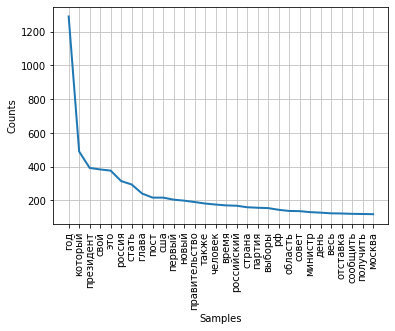

In [201]:
fdist.plot(30,cumulative=False)

In [202]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline


In [203]:
text_raw = " ".join(words)

In [204]:
wordcloud = WordCloud().generate(text_raw)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


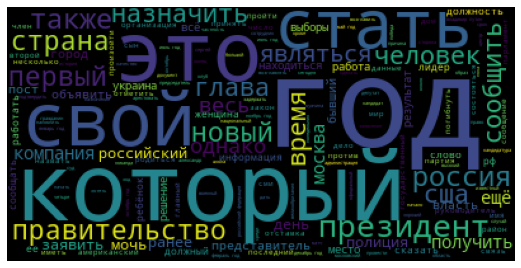

In [205]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud)
plt.axis('off')
plt.subplot(1, 2, 1)